In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Improvements / fixes needed in this notebook:**


1.   Dataset Class creation for ut-zappos and proper relevant data / path handling. (Done, Inference also done)
2.   Model re-loading and inference not working properly, correct its functionality and test it. **(Very Important)**
3.   Research and add relevant evaluation metrics that would indicate the score or quality of generated prompt, as our task is primarily concerned with prompt fine-tuning. **(Very Very Important)**

Kindly see the following chat https://chatgpt.com/share/674e5e47-afac-800e-b488-b481dac28448 for a starter on what evaluation metrics can be used. This needs to be further researched and properly implemented for the final version of our project. (Important)

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
steer01_ut_zap50k_images_path = kagglehub.dataset_download('steer01/ut-zap50k-images')

print('Data source import complete.')
print(f"Dataset downloaded to: {steer01_ut_zap50k_images_path}")


100%|██████████| 169M/169M [00:08<00:00, 20.4MB/s]

Extracting files...


Data source import complete.
Dataset downloaded to: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1


In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
%%time
import os
import json
from datasets import Dataset
from torch.utils.data import Dataset as TorchDataset, DataLoader
from PIL import Image
import torch
from transformers import AutoProcessor
from sklearn.model_selection import train_test_split

# Define the base directory for images
BASE_DIR = "/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images"

# Load the JSON file
json_file = "/content/compositional_ut_zappos_prompts_cpu_sample.json"  # Replace with your JSON file path
with open(json_file, 'r') as f:
    zappos_data = json.load(f)

# Convert JSON to a Pandas DataFrame
import pandas as pd
zappos_df = pd.DataFrame(zappos_data)

# Limit the dataset to 1,000 samples
subset_df = zappos_df.head(1000)

# Add the full path to the image file
subset_df['image_path'] = subset_df['image_path'].apply(lambda x: os.path.join(BASE_DIR, x))

# Split dataset into training, validation, and test sets
train_df, temp_df = train_test_split(subset_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Map datasets to match the expected format
train_dataset = train_dataset.map(lambda x: {"image": x["image_path"], "caption": x["new_prompt"]})
val_dataset = val_dataset.map(lambda x: {"image": x["image_path"], "caption": x["new_prompt"]})
test_dataset = test_dataset.map(lambda x: {"image": x["image_path"], "caption": x["new_prompt"]})

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Check the first 5 entries
print(train_dataset[0:5])


<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training dataset size: 800
Validation dataset size: 100
Testing dataset size: 100
{'image_path': ['/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Boots.Ankle/7981305.1001.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7382127.389243.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7725978.911.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7419486.385187.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7898529.1522.jpg'], 'new_prompt': ['A photo of Canvas_Boots.Ankle with white color and an unspecified material', 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and an unspecified material', 'A photo of Canvas_Shoes.Sneakers.and.

In [ ]:
#Pytorch dataset class
class UTZapposDataset(TorchDataset):
    def __init__(self, hf_dataset, processor):
        self.hf_dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = Image.open(item["image"]).convert("RGB")
        encoding = self.processor(images=image, return_tensors="pt", padding="max_length")
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}  # Remove batch dimension
        encoding["text"] = item["caption"]
        return encoding

# Collate Function for DataLoader
def collate_fn(batch, processor):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch],
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [ ]:
%%time
from transformers import Blip2Processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

CPU times: user 288 ms, sys: 8.26 ms, total: 296 ms
Wall time: 1.47 s


In [ ]:
# Update PyTorch datasets and DataLoaders
train_dataset = UTZapposDataset(train_dataset, processor)
val_dataset = UTZapposDataset(val_dataset, processor)
test_dataset = UTZapposDataset(test_dataset, processor)

train_loader = DataLoader(
    train_dataset, batch_size=3, shuffle=True, collate_fn=lambda batch: collate_fn(batch, processor)
)
val_loader = DataLoader(
    val_dataset, batch_size=3, shuffle=False, collate_fn=lambda batch: collate_fn(batch, processor)
)
test_loader = DataLoader(
    test_dataset, batch_size=3, shuffle=False, collate_fn=lambda batch: collate_fn(batch, processor)
)

# Check dataloader outputs
for batch in train_loader:
    print(batch["pixel_values"].shape)  # (batch_size, 3, height, width)
    print(batch["input_ids"].shape)  # Tokenized captions
    break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([3, 3, 224, 224])
torch.Size([3, 29])


In [ ]:
%%time
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

CPU times: user 174 ms, sys: 5.97 ms, total: 180 ms
Wall time: 239 ms


In [ ]:
%%time
model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    quantization_config=quant_config)


print("Model loaded with 8-bit quantization.")

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Model loaded with 8-bit quantization.
CPU times: user 16.3 s, sys: 16.8 s, total: 33.1 s
Wall time: 1min 35s


In [ ]:
%%time
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    # task_type=TaskType.SEQ_2_SEQ_LM,  # Task type for BLIP-2
    r=16,  # Low-rank dimension (can be adjusted based on memory/performance trade-off)
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout to avoid overfitting
    target_modules=["q_proj", "v_proj"],  # BLIP-2 attention layers
    bias="none"  # No bias adaptation
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters to verify LoRA is applied
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398
CPU times: user 350 ms, sys: 19.8 ms, total: 369 ms
Wall time: 403 ms


In [ ]:
processor.tokenizer.pad_token_id

1

In [ ]:
%%time
# Import necessary libraries
from sklearn.model_selection import train_test_split
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm

num_epochs = 5
optimizer = AdamW(model.parameters(), lr=5e-4)
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training and validation loop with metrics tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    # Training Phase
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training")
    for batch in progress_bar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        labels = input_ids.clone()

        outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

        total_train_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_train_predictions += (predictions == labels).sum().item()
        total_train_samples += labels.numel()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation")
        for batch in progress_bar:
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = input_ids.clone()

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1 - Validation: 100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch 1:
  Training Loss: 0.2868, Training Accuracy: 0.1179
  Validation Loss: 0.0861, Validation Accuracy: 0.1107


Epoch 2 - Validation: 100%|██████████| 34/34 [00:14<00:00,  2.42it/s]


Epoch 2:
  Training Loss: 0.0766, Training Accuracy: 0.1269
  Validation Loss: 0.0794, Validation Accuracy: 0.1107


Epoch 3 - Validation: 100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Epoch 3:
  Training Loss: 0.0631, Training Accuracy: 0.1254
  Validation Loss: 0.0684, Validation Accuracy: 0.1107


Epoch 4 - Validation: 100%|██████████| 34/34 [00:14<00:00,  2.36it/s]


Epoch 4:
  Training Loss: 0.4375, Training Accuracy: 0.1275
  Validation Loss: 2.0393, Validation Accuracy: 0.1372


Epoch 5 - Validation: 100%|██████████| 34/34 [00:14<00:00,  2.39it/s]

Epoch 5:
  Training Loss: 0.5198, Training Accuracy: 0.1395
  Validation Loss: 0.2275, Validation Accuracy: 0.1107
CPU times: user 13min 43s, sys: 1min 28s, total: 15min 11s
Wall time: 15min 22s


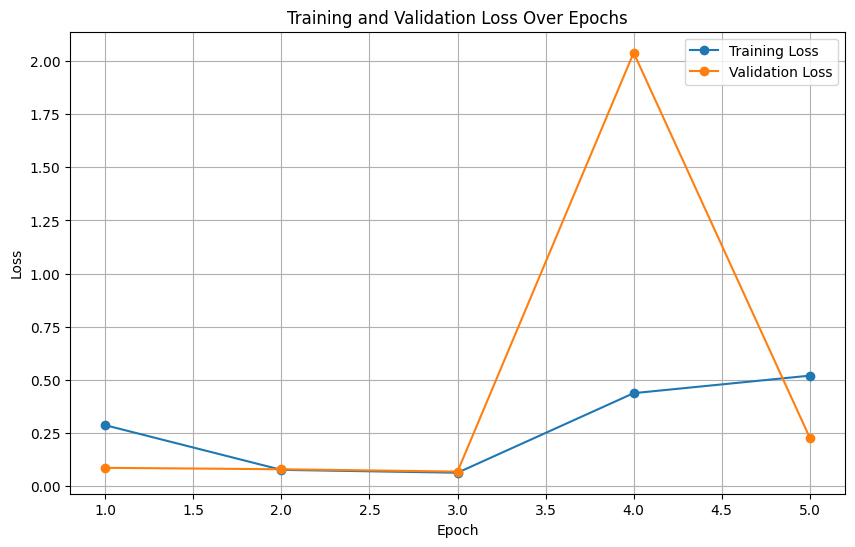

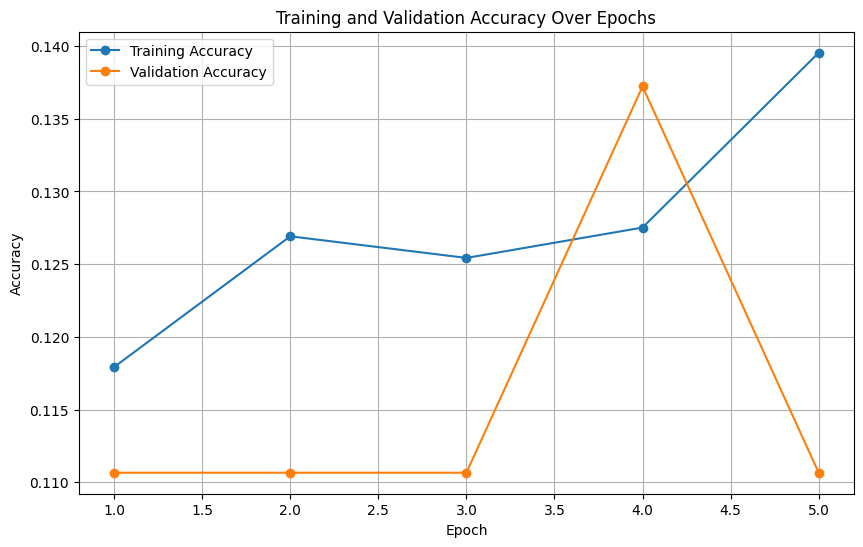

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
%%time
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm

num_epochs = 15
optimizer = AdamW(model.parameters(), lr=5e-4)
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(num_epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    for batch in progress_bar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

model.save_pretrained("fine_tuned_blip2_lora")
print("Fine-tuning completed and model saved.")

Epoch 1:   4%|▎         | 10/267 [00:07<03:16,  1.31it/s, loss=0.0591]Exception ignored in: <function _xla_gc_callback at 0x7ae12ad9e440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Epoch 1:  13%|█▎        | 35/267 [00:24<02:44,  1.41it/s, loss=0.0731]


KeyboardInterrupt: 

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
        print(f"Gradient issue in {name}")

In [ ]:
import shutil

# Create a zip file of the fine-tuned model
shutil.make_archive("/content/fine_tuned_blip2_lora", 'zip', "/content/fine_tuned_blip2_lora")


'/content/fine_tuned_blip2_lora.zip'

In [ ]:
from google.colab import files

# Download the zip file
files.download("fine_tuned_blip2_lora.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Evaluation**

**Semantic Similarity**

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
from PIL import Image

# Load semantic similarity model
semantic_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_caption(image_path, model, processor, device, max_length=50):
    """Generate a caption for an image."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=5,
            early_stopping=True
        )
    return processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_semantic_similarity(generated, reference):
    """Evaluate semantic similarity using SentenceTransformer embeddings."""
    gen_emb = semantic_model.encode(generated, convert_to_tensor=True)
    ref_emb = semantic_model.encode(reference, convert_to_tensor=True)
    similarity = util.cos_sim(gen_emb, ref_emb).item()
    return similarity

# Example usage
image_path = "/content/7965307.5291.jpg"  # Replace with an actual image path
reference_caption = "A photo of Patent.Leather_Boots.Ankle with black color and rubber material."  # Replace with reference caption
generated_caption = generate_caption(image_path, model, processor, device)
similarity_score = evaluate_semantic_similarity(generated_caption, reference_caption)
print(f"Generated Caption: {generated_caption}")
print(f"Semantic Similarity Score: {similarity_score}")


Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with brown color and an unspecified material
Semantic Similarity Score: 0.7137129902839661


**BLEU Score**

In [ ]:
import json
from nltk.translate.bleu_score import sentence_bleu
import statistics

# Function to calculate BLEU score for all captions
def calculate_average_bleu(captions_data):
    bleu_scores = []
    for data in captions_data:
        generated_tokens = data["generated_caption"].split()
        reference_tokens = data["new_prompt"].split()
        score = sentence_bleu([reference_tokens], generated_tokens)
        bleu_scores.append(score)
    return bleu_scores, statistics.mean(bleu_scores)

# Load the JSON file containing caption data
file_path = "/content/test_dataset_captions.json"  # Replace with the actual path to your JSON file

try:
    with open(file_path, 'r') as file:
        captions_data = json.load(file)

    # Calculate BLEU scores and the average
    bleu_scores, avg_bleu = calculate_average_bleu(captions_data)

    # Output results
    for i, data in enumerate(captions_data):
        print(f"Image Path: {data['image_path']}")
        print(f"Generated Caption: {data['generated_caption']}")
        print(f"Reference Prompt: {data['new_prompt']}")
        print(f"BLEU Score: {bleu_scores[i]:.4f}\n")

    print(f"Average BLEU Score for Dataset: {avg_bleu:.4f}")

except FileNotFoundError:
    print(f"The file at {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error decoding JSON data from {file_path}.")
except Exception as e:
    print(f"An error occurred: {e}")


Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7319043.385004.jpg
Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material
Reference Prompt: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material
BLEU Score: 1.0000

Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7801398.32063.jpg
Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with brown color and fabric material
Reference Prompt: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and fabric material
BLEU Score: 0.5954

Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7801399.41336.jpg
Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic

In [ ]:
print(f"Average BLEU Score for Dataset: {avg_bleu:.4f}")

Average BLEU Score for Dataset: 0.7751


**ROUGE Score**

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=aaaf75dcea3c2d2fc20ed176679649a50ad4772e4abcc649d1637d6c90eb16b5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import json
from rouge_score import rouge_scorer

# Function to evaluate ROUGE scores
def evaluate_rouge_score(generated, reference):
    """Evaluate ROUGE score."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Load the JSON file containing caption data
file_path = "/content/test_dataset_captions.json"  # Replace with the actual path to your JSON file

try:
    with open(file_path, 'r') as file:
        captions_data = json.load(file)

    # Initialize variables to accumulate ROUGE scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    # Loop through the dataset and calculate ROUGE scores
    for data in captions_data:
        generated_caption = data["generated_caption"]
        reference_caption = data["new_prompt"]

        # Calculate ROUGE scores
        rouge_scores = evaluate_rouge_score(generated_caption, reference_caption)

        # Append scores for averaging
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Output individual scores (optional)
        print(f"Image Path: {data['image_path']}")
        print(f"Generated Caption: {generated_caption}")
        print(f"Reference Prompt: {reference_caption}")
        print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}")
        print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.4f}")
        print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}\n")

    # Calculate the mean of the ROUGE scores
    mean_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    mean_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    mean_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    # Output the mean scores
    print(f"Mean ROUGE-1: {mean_rouge1:.4f}")
    print(f"Mean ROUGE-2: {mean_rouge2:.4f}")
    print(f"Mean ROUGE-L: {mean_rougeL:.4f}")

except FileNotFoundError:
    print(f"The file at {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error decoding JSON data from {file_path}.")
except Exception as e:
    print(f"An error occurred: {e}")


Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7319043.385004.jpg
Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material
Reference Prompt: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material
ROUGE-1: 1.0000
ROUGE-2: 1.0000
ROUGE-L: 1.0000

Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7801398.32063.jpg
Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with brown color and fabric material
Reference Prompt: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and fabric material
ROUGE-1: 0.9032
ROUGE-2: 0.8276
ROUGE-L: 0.9032

Image Path: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7801399.41336.jpg
Genera

In [ ]:
print(f"Mean ROUGE-1: {mean_rouge1:.4f}")
print(f"Mean ROUGE-2: {mean_rouge2:.4f}")
print(f"Mean ROUGE-L: {mean_rougeL:.4f}")

Mean ROUGE-1: 0.9211
Mean ROUGE-2: 0.8580
Mean ROUGE-L: 0.9204


# INFERENCE

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.65 ms


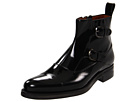

In [ ]:
%%time
from PIL import Image
# load image
# example = dataset[0]
# image = example["image"]
# t_img_path = "/kaggle/input/inf-img-01/7909514.680.jpg"
# t_img_path = "/kaggle/input/inf-img-02/109671650_f7bbc297fa.jpg"
#t_img_path = "/content/109671650_f7bbc297fa.jpg"
t_img_path = "/content/7965307.5291.jpg"
image = Image.open(t_img_path).convert("RGB")
image

In [ ]:
%%time

def generate_caption(image_path, model, processor, device, max_length=50):
    """
    Generate a caption for a given image using the fine-tuned BLIP-2 model.

    Args:
        image_path (str): Path to the image.
        model: Fine-tuned BLIP-2 model.
        processor: BLIP-2 processor for image and text.
        device: Device to run inference (CPU/GPU).
        max_length (int): Maximum length of the generated caption.

    Returns:
        str: Generated caption.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    with torch.no_grad():
        outputs = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=5,  # Beam search for better results
            early_stopping=True
        )

    # Decode the generated text
    caption = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    return caption

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [ ]:
%%time
# Example image path
# test_image_path = "/content/7965307.5291.jpg"

# Generate caption
caption = generate_caption(t_img_path, model, processor, device)
print(f"Generated Caption: {caption}")

Generated Caption: A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with brown color and an unspecified material
CPU times: user 7.8 s, sys: 22.7 ms, total: 7.82 s
Wall time: 9.88 s


In [ ]:
import json
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load models
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def evaluate_caption_quality(data):
    results = []

    for entry in data:
        image_path = entry["image_path"]
        generated_caption = entry["generated_caption"]
        new_prompt = entry["new_prompt"]

        try:
            # 1. CLIP Similarity
            image = Image.open(image_path)
            inputs_generated = clip_processor(images=image, text=[generated_caption], return_tensors="pt", padding=True)
            inputs_ground_truth = clip_processor(images=image, text=[new_prompt], return_tensors="pt", padding=True)

            outputs_generated = clip_model(**inputs_generated)
            outputs_ground_truth = clip_model(**inputs_ground_truth)

            clip_sim_generated = outputs_generated.logits_per_text[0].item()  # Single similarity score for generated_caption
            clip_sim_ground_truth = outputs_ground_truth.logits_per_text[0].item()  # Single similarity score for new_prompt

            # 2. Semantic Similarity (with SentenceTransformer)
            emb_gen = semantic_model.encode(generated_caption, convert_to_tensor=True)
            emb_truth = semantic_model.encode(new_prompt, convert_to_tensor=True)
            semantic_similarity = util.pytorch_cos_sim(emb_gen, emb_truth).item()

            # Track human alignment need and final prediction
            if clip_sim_generated > clip_sim_ground_truth:
                if semantic_similarity < 0.75:
                    human_alignment_needed = "Yes"
                    final_caption = generated_caption
                    prediction = "Correct"
                else:
                    human_alignment_needed = "No"
                    final_caption = generated_caption
                    prediction = "Correct"
            elif clip_sim_generated < clip_sim_ground_truth:
                if semantic_similarity < 0.75:
                    human_alignment_needed = "Yes"
                    final_caption = new_prompt
                    prediction = "Wrong"
                else:
                    human_alignment_needed = "No"
                    final_caption = new_prompt
                    prediction = "Wrong"
            else:
                human_alignment_needed = "No"
                final_caption = generated_caption
                prediction = "balanced"

            # Append result to the list as a dictionary
            results.append({
                "image_path": image_path,
                "generated_caption": generated_caption,
                "new_prompt": new_prompt,
                "clip_similarity": [clip_sim_generated, clip_sim_ground_truth],
                "semantic_similarity": semantic_similarity,
                "human_alignment_needed": human_alignment_needed,
                "final_caption": final_caption,
                "prediction": prediction
            })

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue  # Skip the current image and continue with the next one

    return results

# Function to read JSON file and process
def process_json_file(file_path):
    try:
        # Load the JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Evaluate the data
        results = evaluate_caption_quality(data)

        return results
    except Exception as e:
        print(f"Error reading or processing the JSON file: {e}")
        return None

# Example file path
json_file_path = '/content/test_dataset_captions.json'  # Replace with your actual JSON file path

# Process the file and evaluate
results = process_json_file(json_file_path)
if results:
    # Save results as JSON
    with open('output_results.json', 'w') as f:
        json.dump(results, f, indent=4)
    print(results)


[{'image_path': '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7319043.385004.jpg', 'generated_caption': 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material', 'new_prompt': 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material', 'clip_similarity': [29.171003341674805, 29.171003341674805], 'semantic_similarity': 1.0000001192092896, 'human_alignment_needed': 'No', 'final_caption': 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with an unspecified color and rubber material', 'prediction': 'balanced'}, {'image_path': '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Canvas_Shoes.Sneakers.and.Athletic.Shoes/7801398.32063.jpg', 'generated_caption': 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Shoes with brown color and fabric material', 'new_prompt': 'A photo of Canvas_Shoes.Sneakers.and.Athletic.Sh

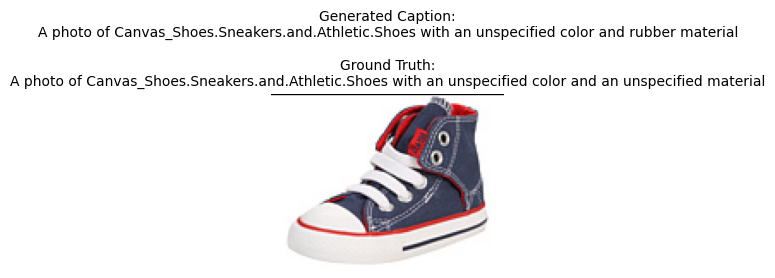

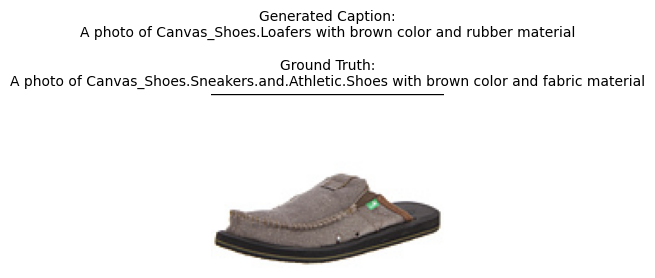

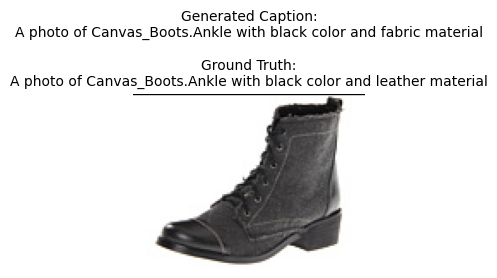

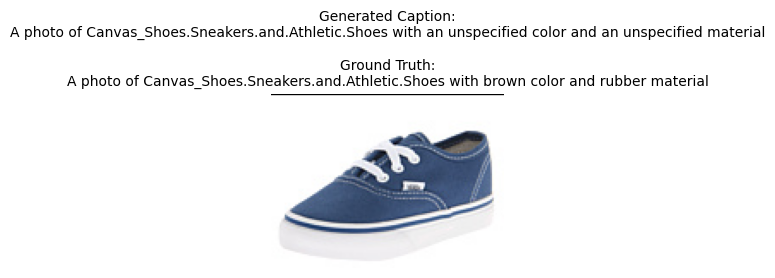

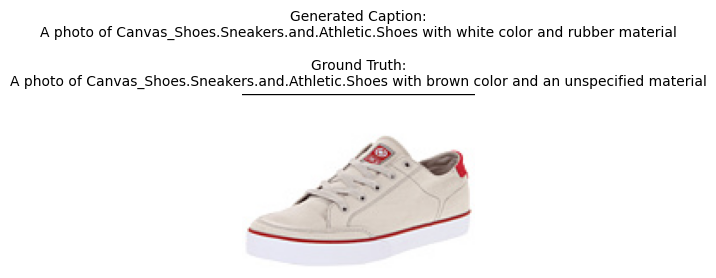

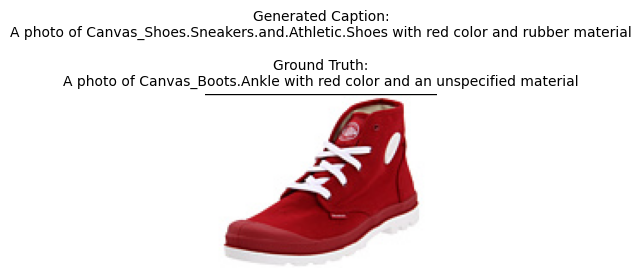

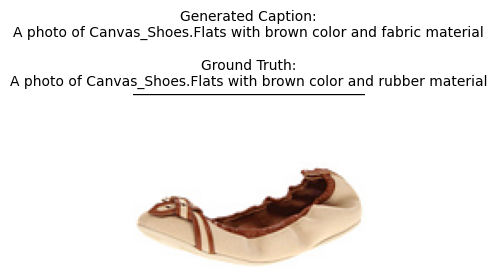

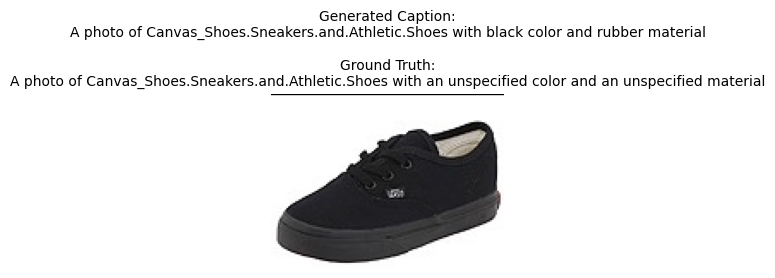

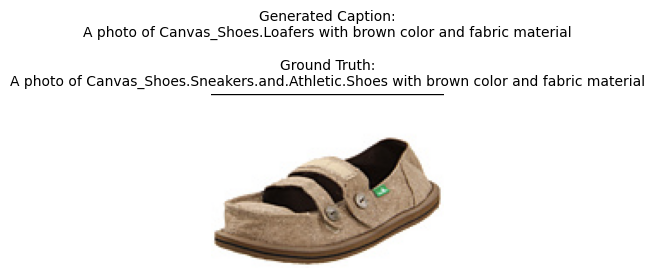

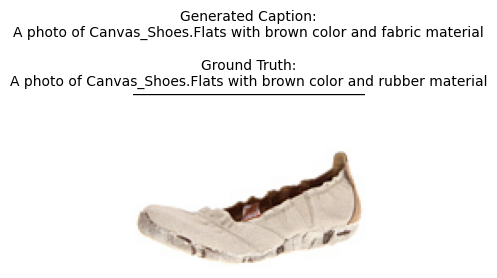

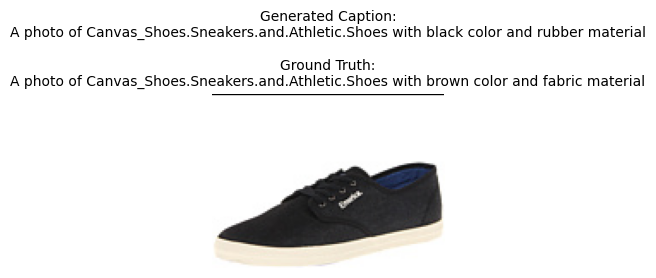

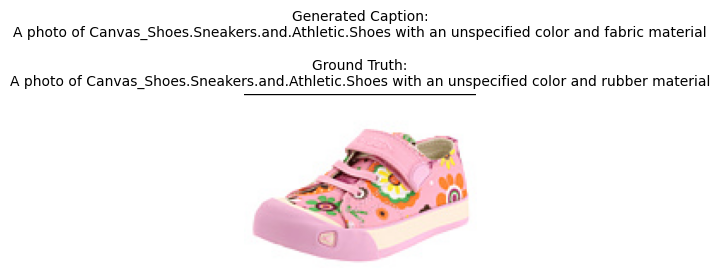

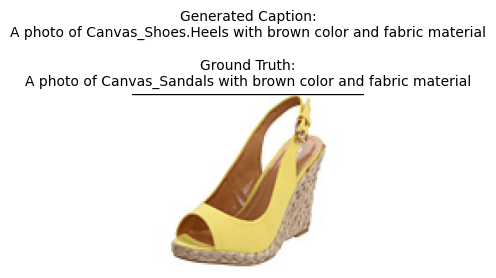

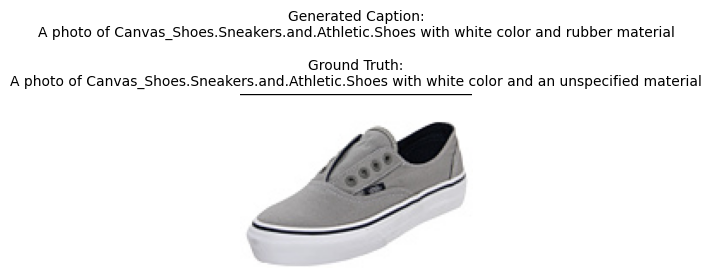

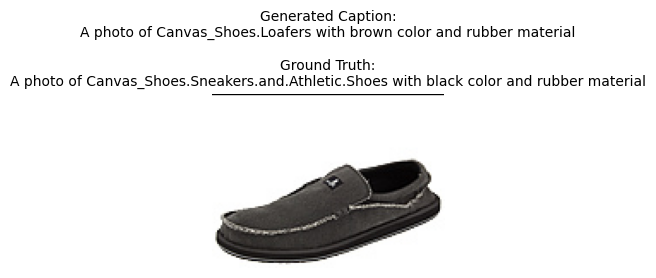

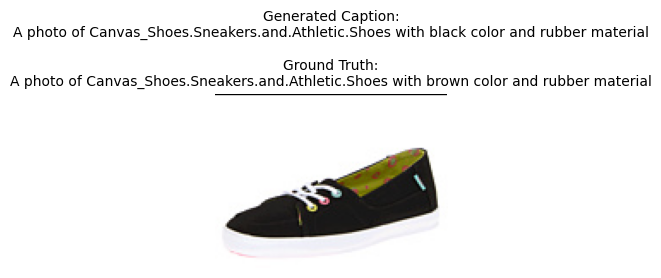

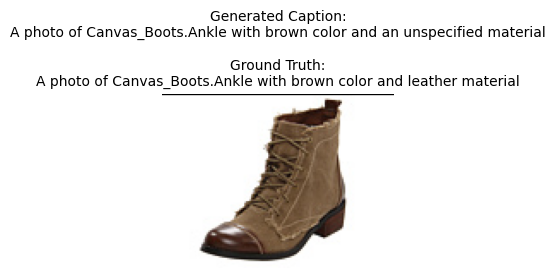

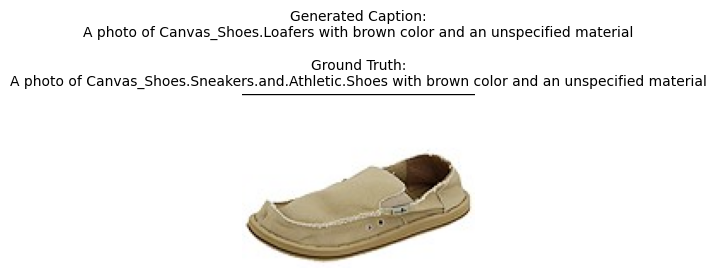

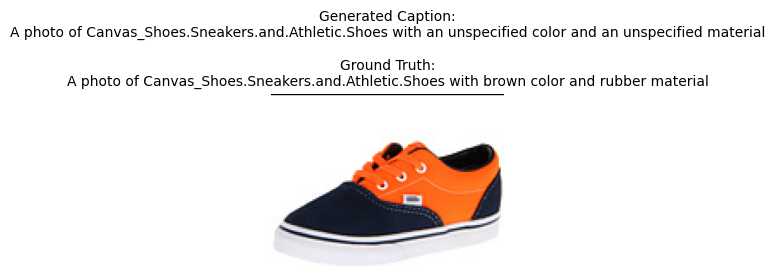

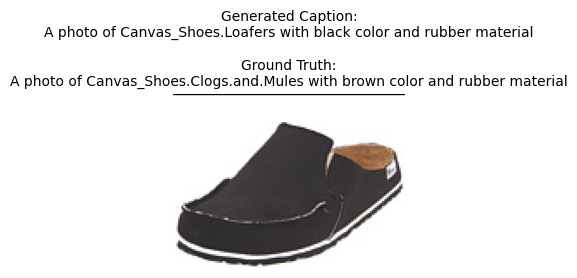

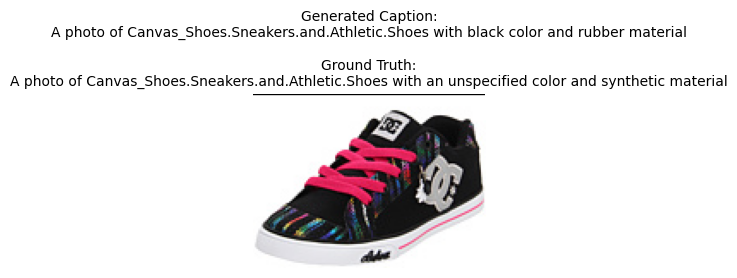

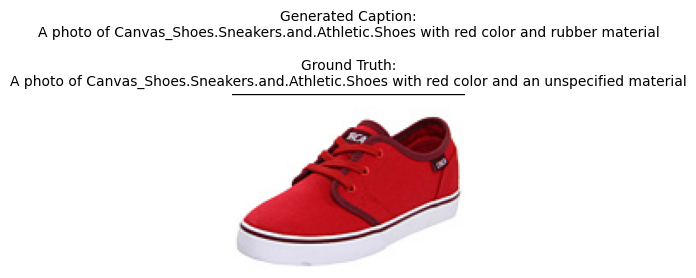

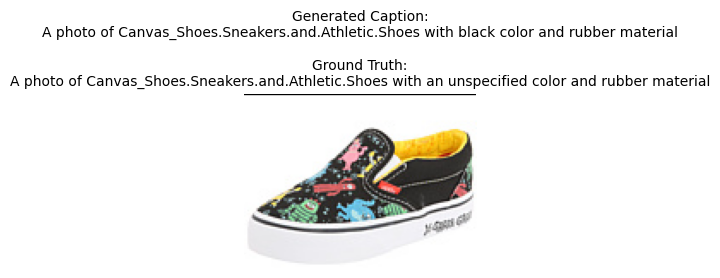

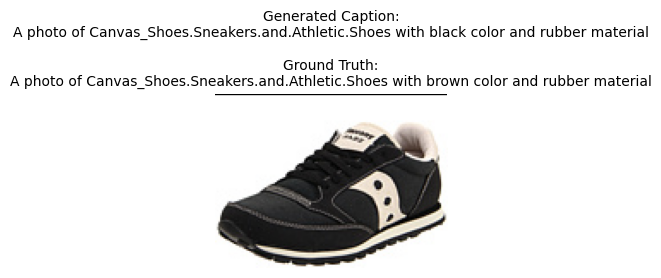

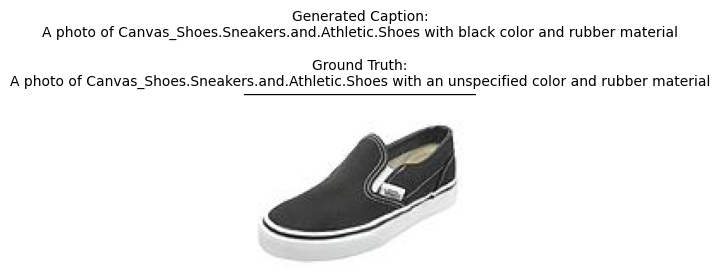

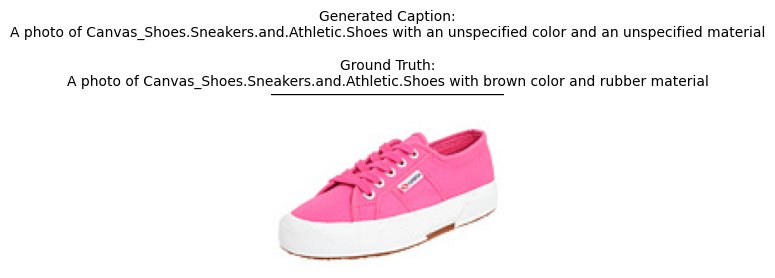

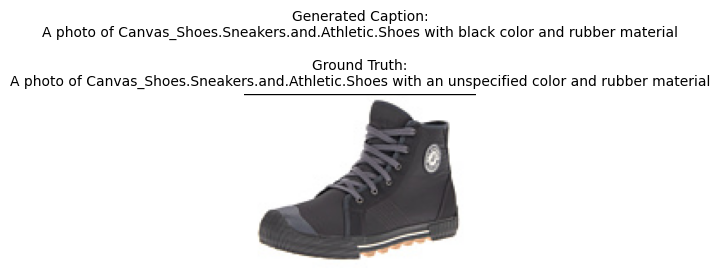

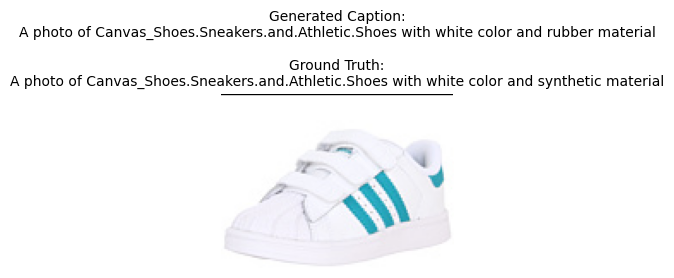

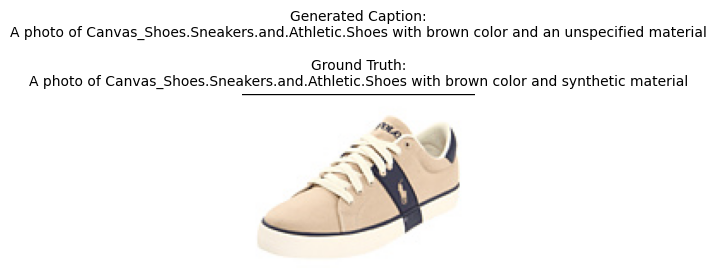

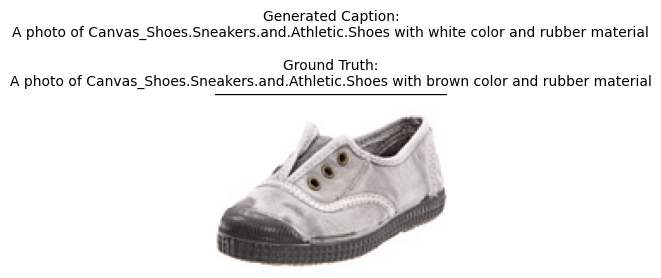

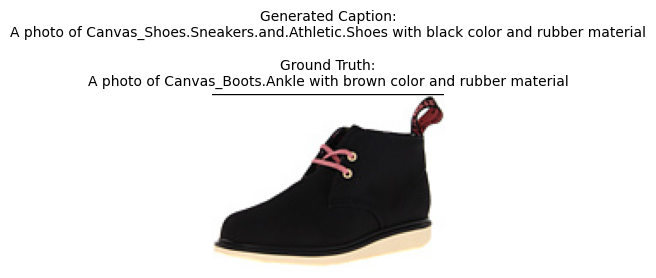

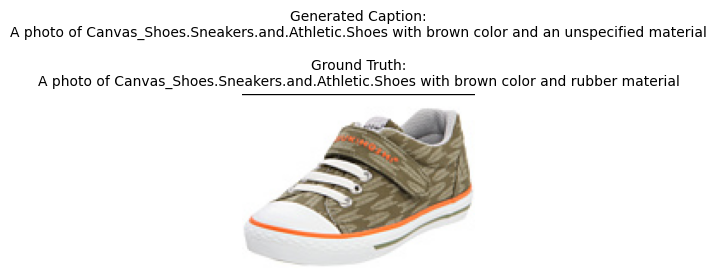

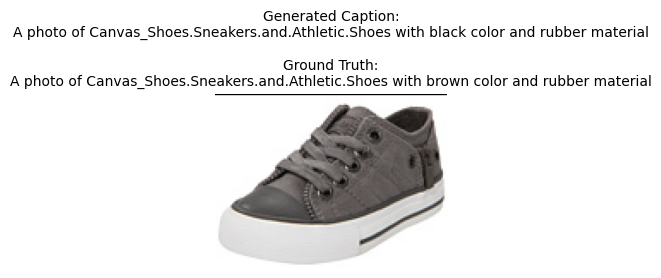

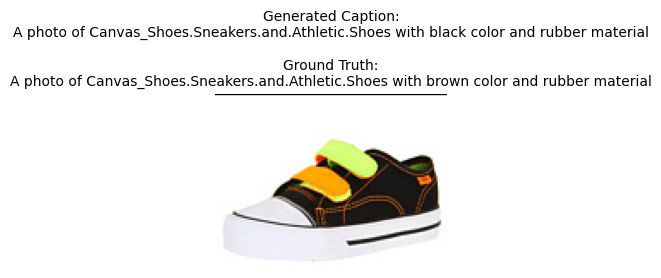

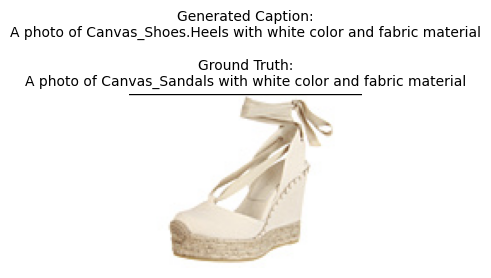

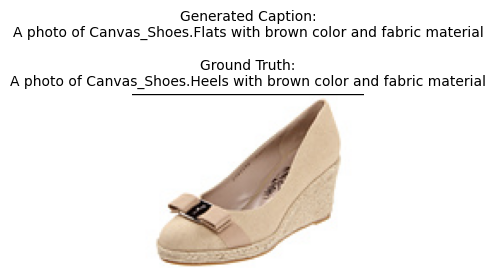

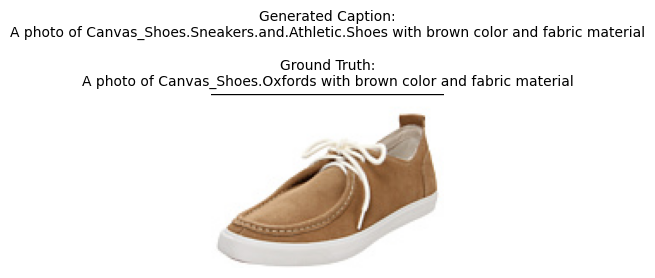

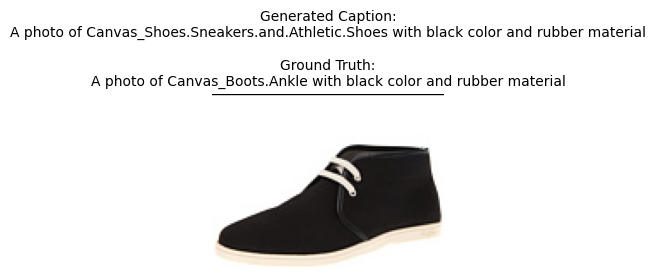

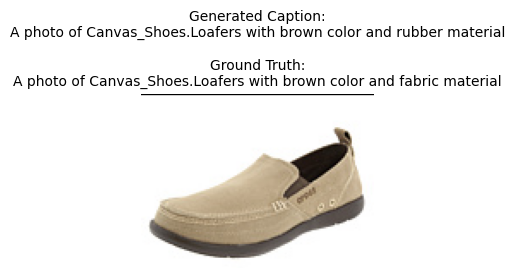

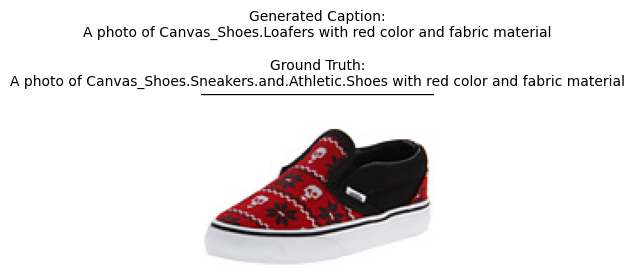

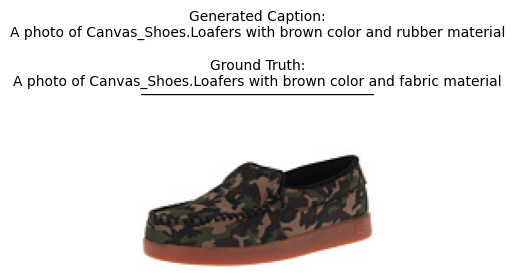

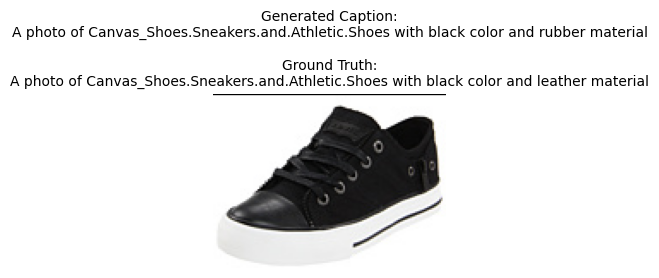

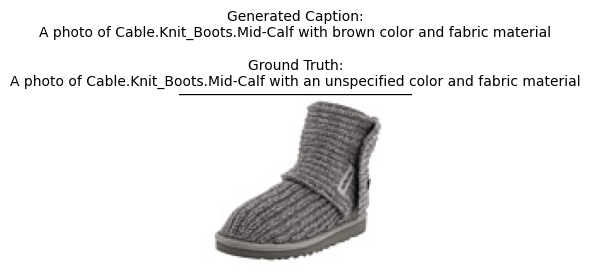

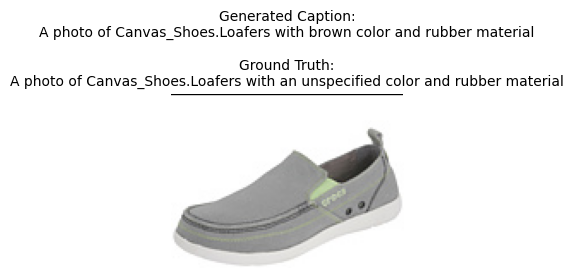

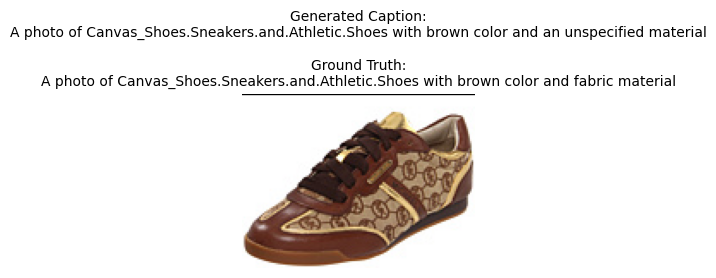

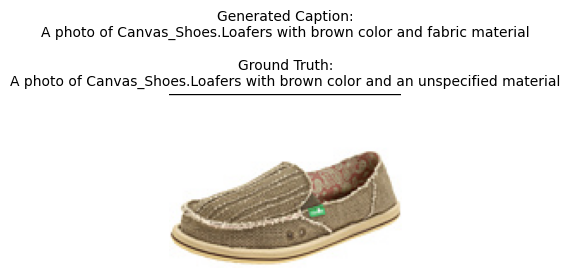

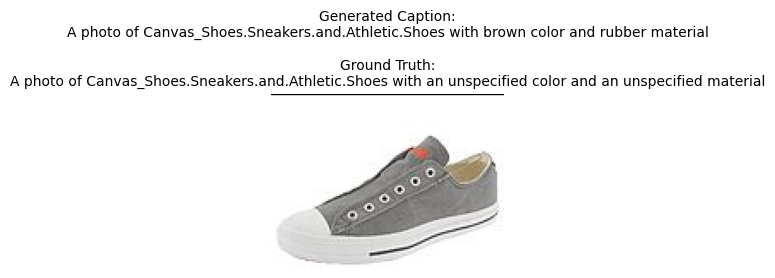

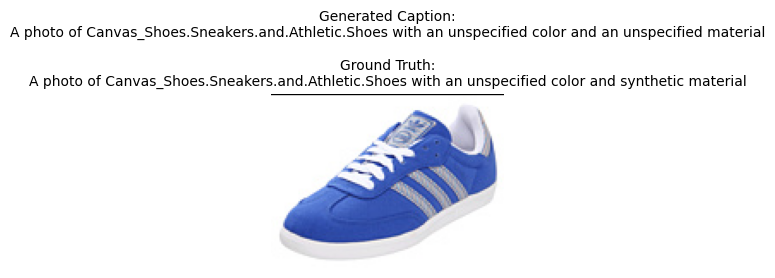

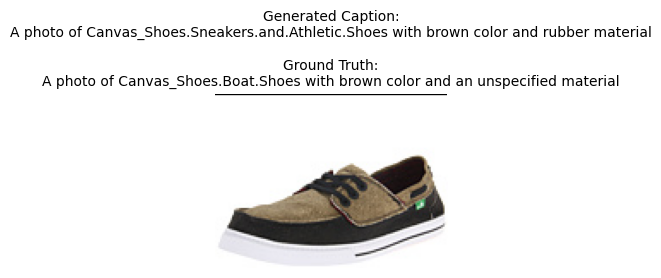

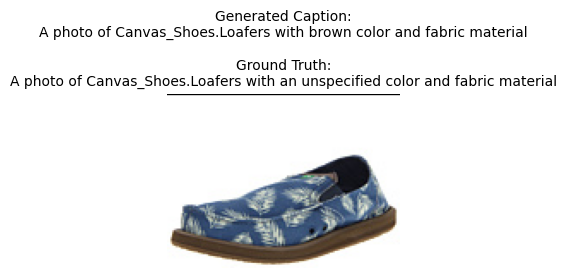

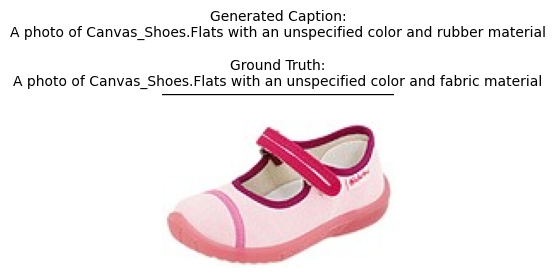

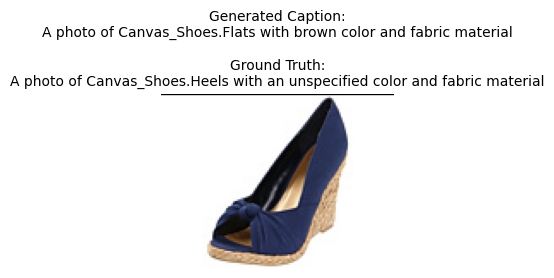

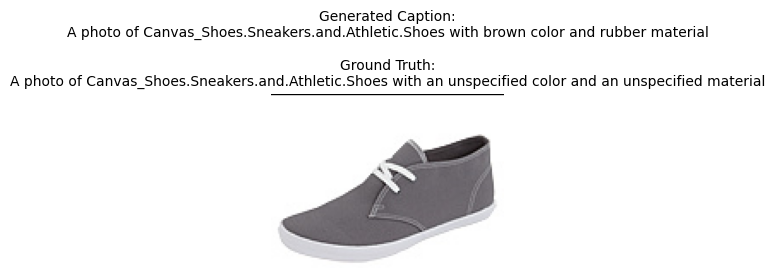

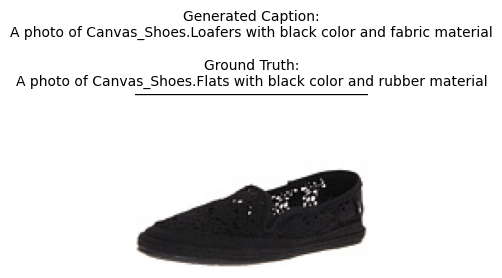

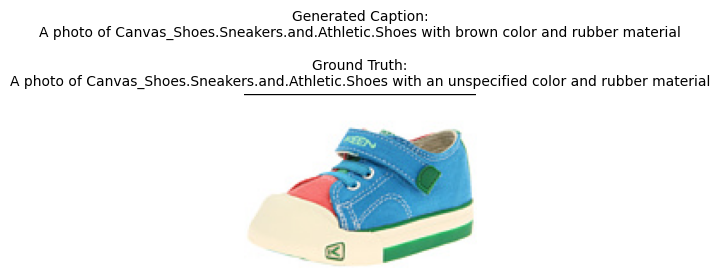

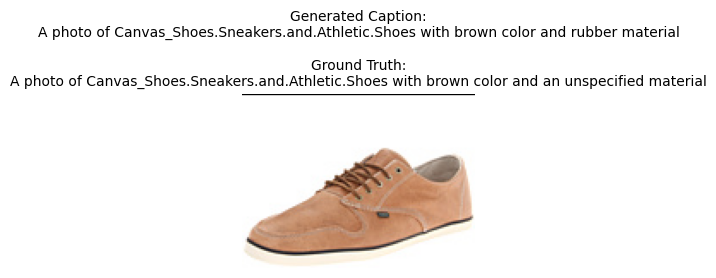

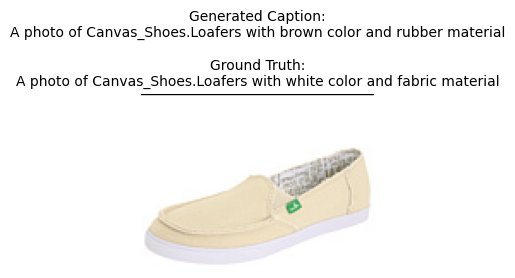

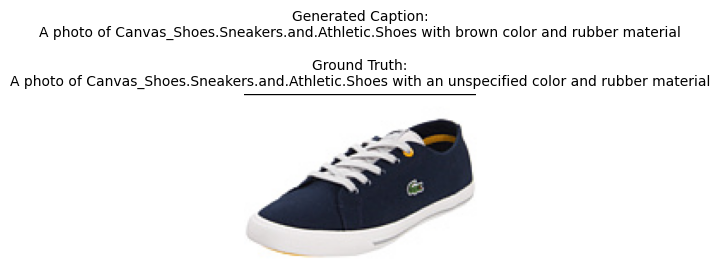

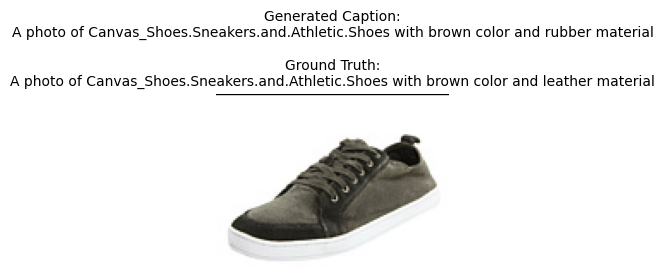

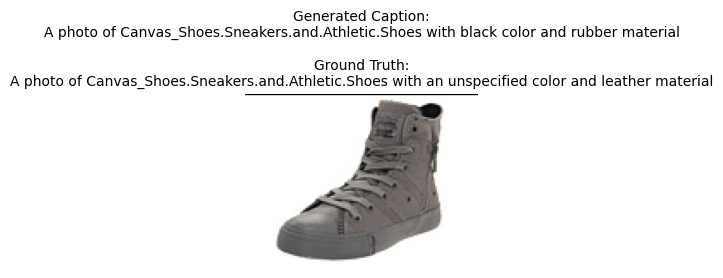

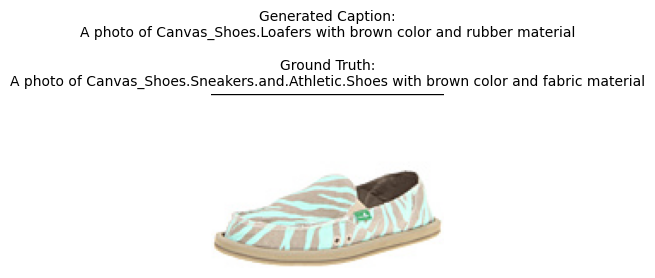

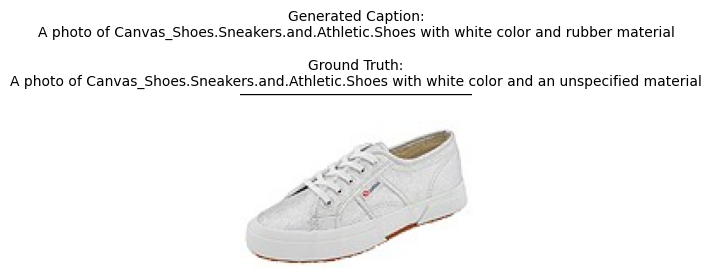

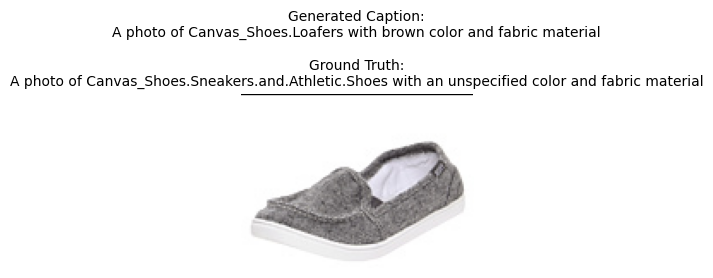

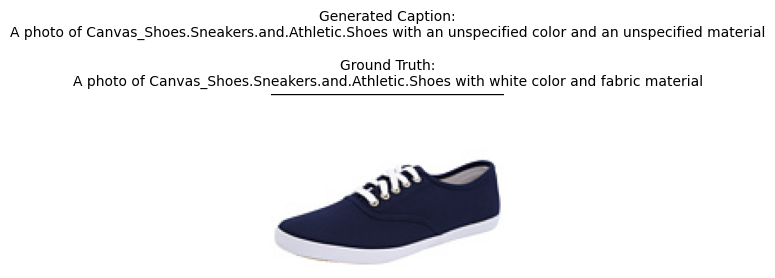

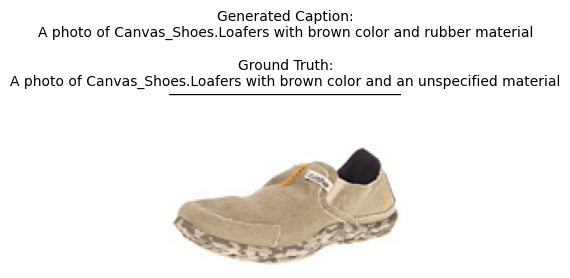

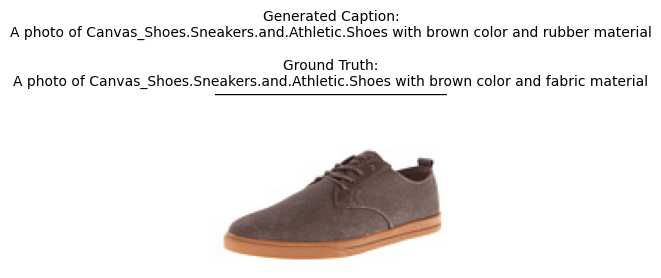

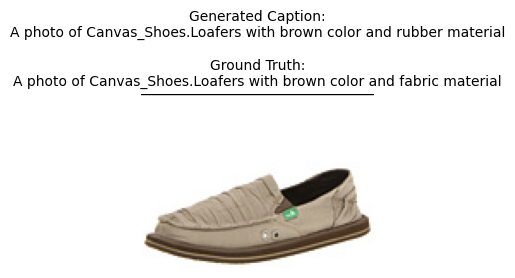

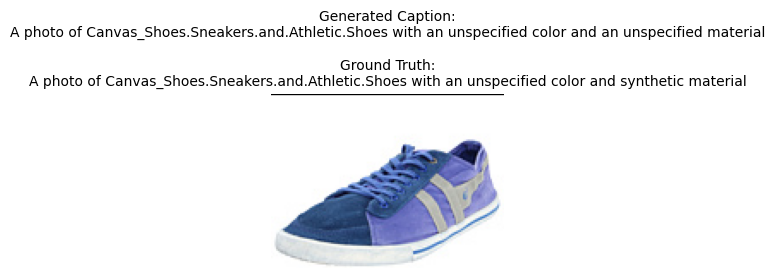

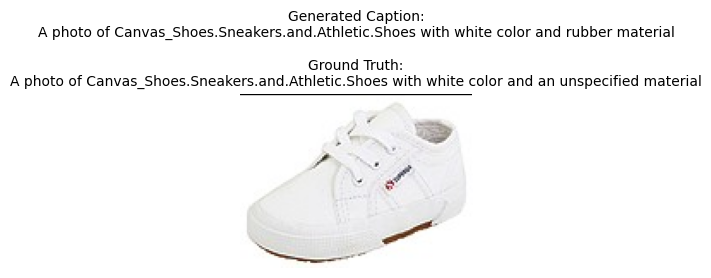

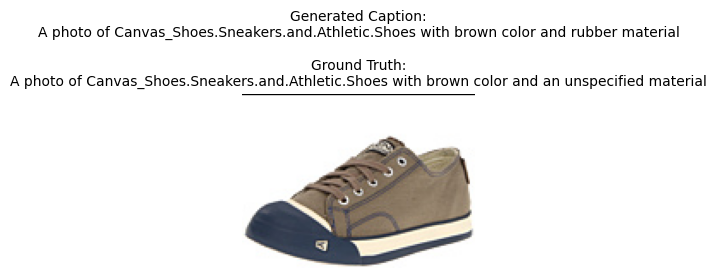

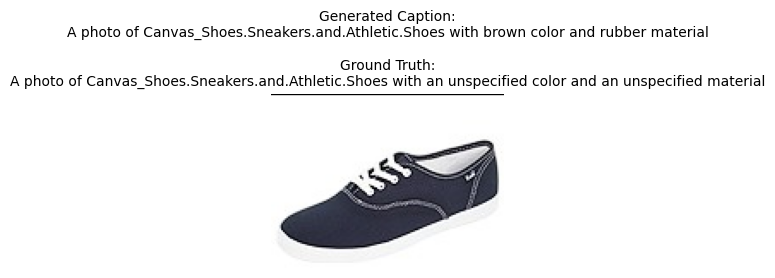

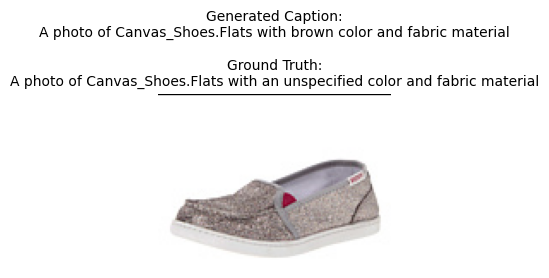

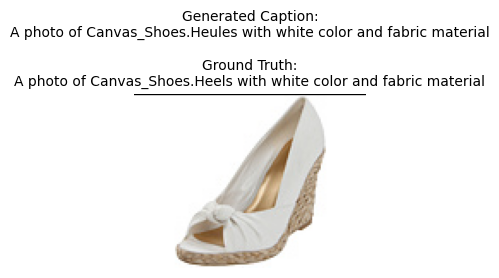

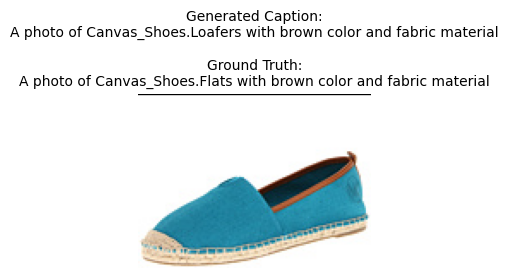

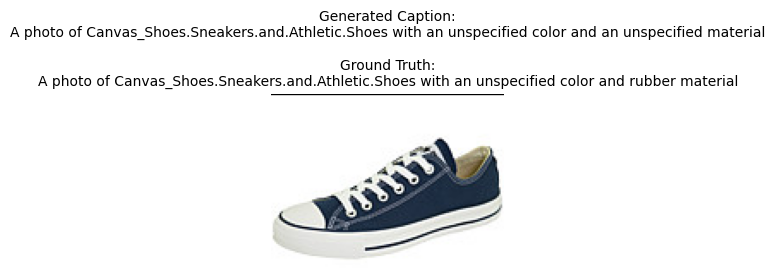

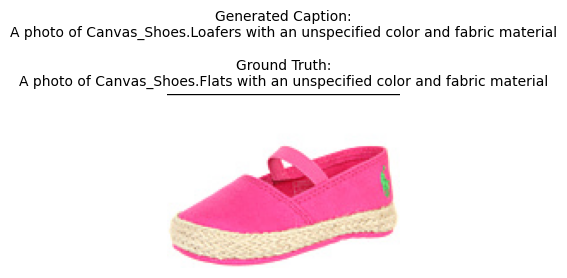

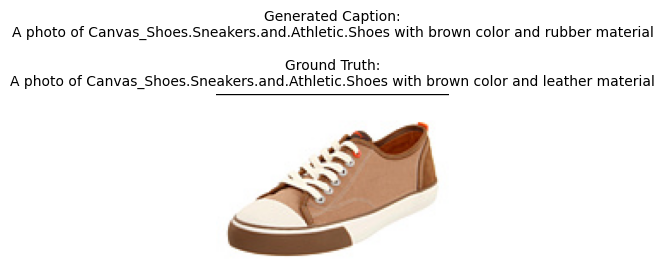

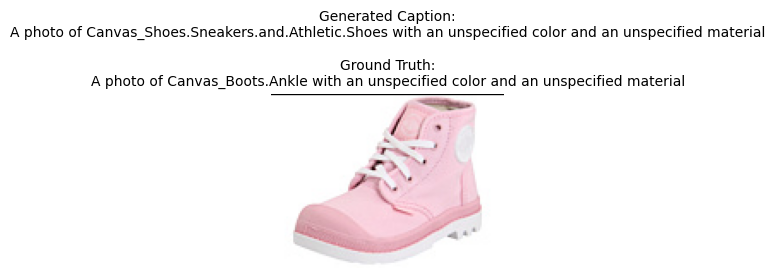

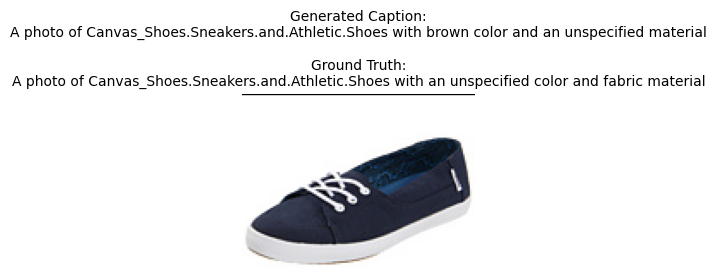

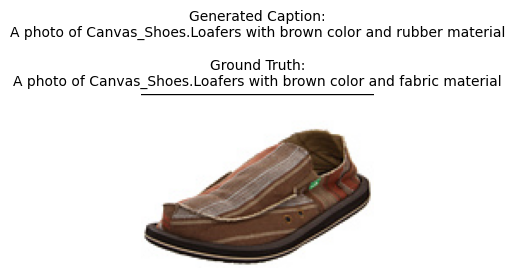

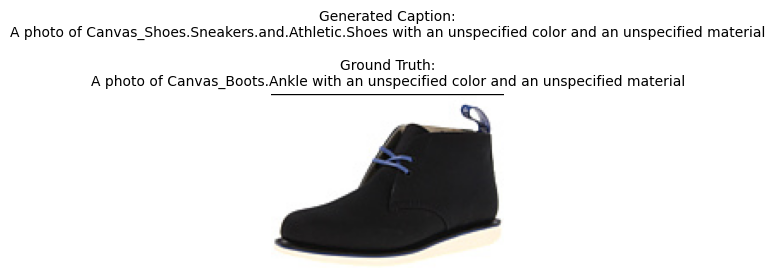

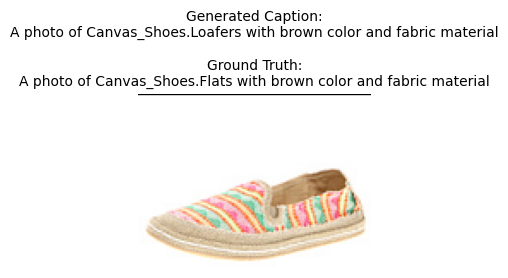

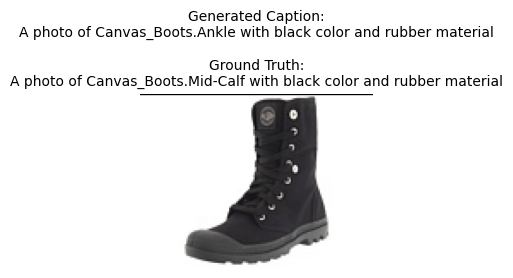

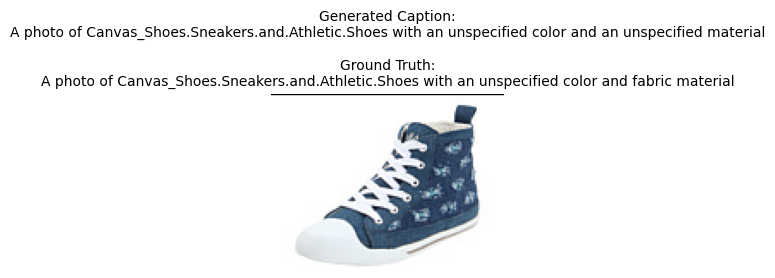

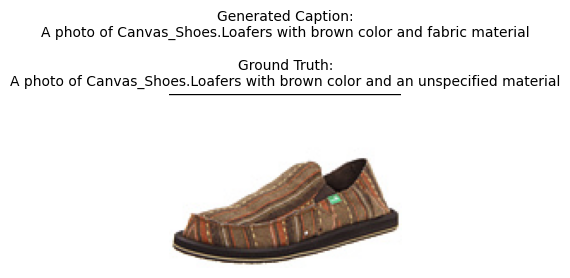

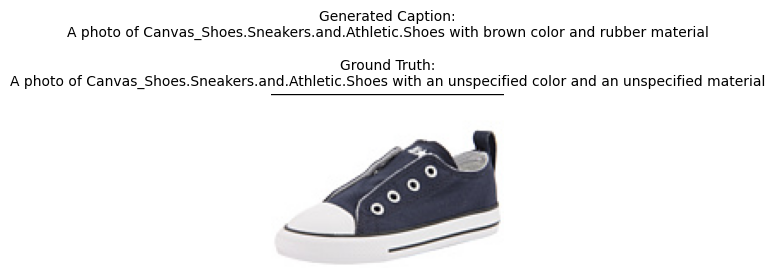

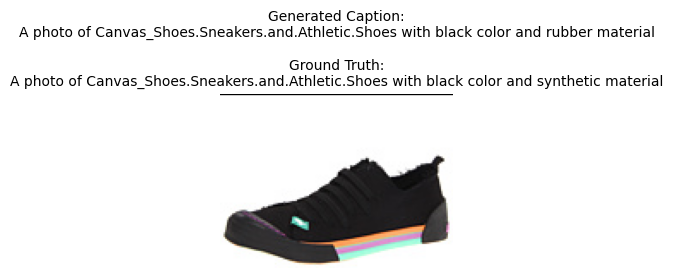

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import sample

# Function to load the results from the JSON file
def load_results(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error reading JSON file: {e}")
        return []

# Separate the results into "Correct" and "Wrong"
def separate_results(data):
    correct_images = [entry for entry in data if entry['prediction'] == 'Correct']
    wrong_images = [entry for entry in data if entry['prediction'] == 'Wrong']

    # Ensure we have at least 10 images in each category
    correct_images = sample(correct_images, min(50, len(correct_images)))
    wrong_images = sample(wrong_images, min(50, len(wrong_images)))

    return correct_images, wrong_images

# Plot the images one by one with separators
def plot_images_separated(correct_images, wrong_images):
    # Plot correct predictions
    for img_data in correct_images:
        img_path = img_data["image_path"]
        generated_caption = img_data["generated_caption"]
        groundTruth = img_data["new_prompt"]

        # Create a new figure for each image
        plt.figure(figsize=(3, 3))
        plt.imshow(mpimg.imread(img_path))
        plt.title(f"Generated Caption:\n{generated_caption}\n\nGround Truth:\n{groundTruth}", fontsize=10)
        plt.axis('off')  # Hide axes

        # Display a line after the image
        plt.axhline(y=0, color='black', linewidth=1)  # Add a line at the bottom

        # Show the image and wait for the user to continue to the next
        plt.show()
          # Wait for user input to continue

    # Plot wrong predictions
    for img_data in wrong_images:
        img_path = img_data["image_path"]
        generated_caption = img_data["generated_caption"]
        groundTruth = img_data["new_prompt"]

        # Create a new figure for each image
        plt.figure(figsize=(3, 3))
        plt.imshow(mpimg.imread(img_path))
        plt.title(f"Generated Caption:\n{generated_caption}\n\nGround Truth:\n{groundTruth}", fontsize=10)
        plt.axis('off')

        # Display a line after the image
        plt.axhline(y=0, color='black', linewidth=1)

        # Show the image and wait for the user to continue to the next
        plt.show()


# Example file path
json_file_path = 'output_results.json'  # Replace with your actual file path

# Load and process results
data = load_results(json_file_path)
correct_images, wrong_images = separate_results(data)

# Plot the images
plot_images_separated(correct_images, wrong_images)


In [ ]:
import json
output_file = "final_file.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=4)

print(f"Captions saved to {output_file}")

Captions saved to final_file.json


In [ ]:
len(results['clip_similarity'])

200

In [ ]:
from random import sample
import matplotlib.pyplot as plt

# Function to decode predictions and references
def decode_caption(tokenizer, input_ids):
    return tokenizer.decode(input_ids, skip_special_tokens=True)

# Lists to store correct and incorrect predictions
correct_predictions = []
wrong_predictions = []

# Model evaluation for predictions
model.eval()
with torch.no_grad():
    for batch in val_loader:  # Use validation loader for evaluation
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        labels = input_ids.clone()

        # Generate predictions
        outputs = model.generate(pixel_values=pixel_values, max_length=50, num_beams=5)
        predictions = [decode_caption(processor.tokenizer, pred) for pred in outputs]
        references = [decode_caption(processor.tokenizer, ref) for ref in labels]

        # Compare predictions with references
        for pred, ref, img_tensor in zip(predictions, references, batch["pixel_values"]):
            if pred.strip() == ref.strip():
                correct_predictions.append((img_tensor, pred, ref))
            else:
                wrong_predictions.append((img_tensor, pred, ref))

        # Stop once we have enough samples
        if len(correct_predictions) >= 5 and len(wrong_predictions) >= 5:
            break

# Select 5 random correct and wrong predictions
correct_samples = sample(correct_predictions, 5)
wrong_samples = sample(wrong_predictions, 5)

 #Visualization Function
def visualize_predictions(samples, title):
    plt.figure(figsize=(10, 20))  # Adjust figure size for better spacing
    num_samples = len(samples)
    for i, (img_tensor, pred, ref) in enumerate(samples, 1):
        # Convert tensor to image
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        plt.subplot(num_samples, 1, i)  # Set up subplots in 5 rows and 1 column
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred:\n{pred}\n\nRef:\n{ref}", fontsize=10)  # Add captions with spacing
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(pad=5.0)  # Add padding to prevent overlap
    plt.show()

# Visualize correct predictions
visualize_predictions(correct_samples, "Correct Predictions")

# Visualize wrong predictions
visualize_predictions(wrong_samples, "Wrong Predictions")




ValueError: Sample larger than population or is negative